In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timezone
import matplotlib.pyplot as plt
from geographiclib.geodesic import Geodesic

In [2]:
catalog_dir = "/uufs/chpc.utah.edu/common/home/koper-group3/alysha/ben_catalogs/20240220"
ys_ev_df = pd.read_csv(f"{catalog_dir}/yellowstone_events_20121001_20240101.csv")
ys_arr_df = pd.read_csv(f'{catalog_dir}/yellowstone_arrivals_gains_20121001_20240101.csv')
ml_df = pd.read_csv(f"{catalog_dir}/earthquakeLocalMagnitudeCatalog.csv")
holt_amps = pd.read_csv('/uufs/chpc.utah.edu/common/home/u1072028/PycharmProjects/ynp_local_magnitude_recalibration/catalogs/amplitudes/yellowstone.amps.clean.csv')
local_mag_outfile_name = "yellowstoneAmplitudesForYP21ML_localMagnitudes_20121001_20240101.csv"

/tmp/ipykernel_301658/3084822438.py:4: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  ml_df = pd.read_csv(f"{catalog_dir}/earthquakeLocalMagnitudeCatalog.csv")


In [3]:
ml_df[['subsource','amp_rflag']].value_counts()

subsource  amp_rflag
Jiggle     F            72406
           H            65548
RT2        A              856
Name: count, dtype: int64

In [4]:
def filter_and_merge_ys_events():
    pass

def add_channel_prefix(df):
    df["Cmp"] = df["seedchan"].str[:-1]

def get_event_feature_info(column_name):
    pass

def merge_channel_rows(station_column_rows):
    pass

def filter_and_merge_stations():
    pass

# Filter amplitude values to yellowstone events, merge the event information

In [5]:
ys_ev_df.head()

,evid,event_lat,event_lon,event_depth,origin_time,magnitude,magnitude_type,rflag,utc
0,60000005,44.743333,-111.067500,5.48,1.349112e+09,-0.20,d,F,2012-10-01 17:26:54.360001+00:00
1,60000010,44.438167,-111.032000,6.05,1.349101e+09,0.35,d,F,2012-10-01 14:24:40.459999+00:00
2,60000050,44.276000,-110.645667,2.18,1.350621e+09,1.15,d,F,2012-10-19 04:29:58.239998+00:00
3,60000060,44.346167,-110.327333,9.44,1.350808e+09,1.34,d,F,2012-10-21 08:32:33.660000+00:00
4,60000065,44.395000,-111.021833,4.71,1.350274e+09,0.82,d,F,2012-10-15 04:14:30.209999+00:00


In [6]:
n_ys_amps = ml_df[ml_df['evid'].isin(ys_ev_df['evid'])].shape[0]
print(f"There are {n_ys_amps} amplitudes for Yellowstone events out of {ml_df.shape[0]} total amplitudes")

There are 53971 amplitudes for Yellowstone events out of 138810 total amplitudes


In [7]:
# Filter amps to just ys
ml_df = ml_df.merge(ys_ev_df, on='evid', how='inner')
assert ml_df.shape[0] == n_ys_amps

In [8]:
ml_df[['event_lon', 'event_lat']].describe().loc[['min', 'max']]

,event_lon,event_lat
min,-111.327833,44.000167
max,-109.939500,45.129000


In [90]:
ml_df[['Date']].min()

Date    2012-10-07 00:32:04.740000+00:00
dtype: object

In [91]:
ml_df[['Date']].max()

Date    2023-12-29 09:38:37.689999+00:00
dtype: object

# Add a column for the channel prefix, for merging

In [9]:
ml_df["Cmp"] = ml_df["seedchan"].str[:-1]

In [10]:
ml_df.head()

,evid,sta,net,seedchan,location,magtype,auth,subsource,amplitude,amptype,...,snr,event_lat,event_lon,event_depth,origin_time,magnitude,magnitude_type,rflag,utc,Cmp
0,60000620,LKWY,US,BHE,01,l,UU,Jiggle,1.014206,WAS,...,4.326750,44.4745,-110.552667,4.43,1.357546e+09,2.19,l,F,2013-01-07 08:12:32.649998+00:00,BH
1,60000620,LKWY,US,BHN,01,l,UU,Jiggle,0.544203,WAS,...,4.276043,44.4745,-110.552667,4.43,1.357546e+09,2.19,l,F,2013-01-07 08:12:32.649998+00:00,BH
2,60000620,YFT,WY,HHE,01,l,UU,Jiggle,0.163640,WAS,...,3.057469,44.4745,-110.552667,4.43,1.357546e+09,2.19,l,F,2013-01-07 08:12:32.649998+00:00,HH
3,60000620,YUF,WY,HHN,01,l,UU,Jiggle,0.408221,WAS,...,5.097910,44.4745,-110.552667,4.43,1.357546e+09,2.19,l,F,2013-01-07 08:12:32.649998+00:00,HH
4,60000620,YUF,WY,HHE,01,l,UU,Jiggle,0.339141,WAS,...,5.399999,44.4745,-110.552667,4.43,1.357546e+09,2.19,l,F,2013-01-07 08:12:32.649998+00:00,HH


# Remove some of the unnecessary columns. Rename remaining to match/be more similar to the style of Holt (2022) data

In [11]:
ml_df = ml_df[['evid', 'sta', 'net', 'seedchan', 'location', 'magtype', 'amplitude', 'units', 'mag',
       'magres', 'magcorr', 'subsource', 'period', 'snr', 'event_lat',
       'event_lon', 'event_depth', 'origin_time', 'magnitude',
       'magnitude_type', 'utc', 'Cmp']]

In [12]:
ml_df.columns = ['Evid', 'Sta', 'Net', 'Chan', 'Loc', 'SMagType', 'Amp', 'Un', 'SML',
       'SMLRes', 'Corr', 'Source', 'Per', 'Snr', 'EqLat',
       'EqLon', 'EqDep', 'EqOt', 'CatMag',
       'CatMagType', 'Date', 'Cmp']

In [13]:
ml_stat_counts = (ml_df[ml_df['CatMagType'] == 'l']['Sta'].value_counts()//2).reset_index()

In [14]:
ml_stat_counts

,Sta,count
0,YMR,6709
1,YNR,6599
2,YFT,3789
3,YHB,3720
4,YUF,2281
5,LKWY,1752
6,BOZ,919
7,AHID,203
8,HLID,134
9,BW06,123


In [15]:
ml_df[ml_df['Evid'] == 60408292]

,Evid,Sta,Net,Chan,Loc,SMagType,Amp,Un,SML,SMLRes,...,Per,Snr,EqLat,EqLon,EqDep,EqOt,CatMag,CatMagType,Date,Cmp
38923,60408292,YDD,WY,HHN,01,l,0.315392,cm,1.57,0.26,...,0.18,25.122896,44.324833,-110.537167,5.59,1.599315e+09,1.31,l,2020-09-05 14:13:15.040000+00:00,HH
38924,60408292,YDD,WY,HHE,01,l,0.151407,cm,1.57,0.26,...,0.12,17.893585,44.324833,-110.537167,5.59,1.599315e+09,1.31,l,2020-09-05 14:13:15.040000+00:00,HH
38925,60408292,LKWY,US,BH1,00,l,0.011932,cm,1.06,-0.25,...,0.15,3.281011,44.324833,-110.537167,5.59,1.599315e+09,1.31,l,2020-09-05 14:13:15.040000+00:00,BH
38926,60408292,LKWY,US,BH2,00,l,0.019847,cm,1.06,-0.25,...,0.30,3.461973,44.324833,-110.537167,5.59,1.599315e+09,1.31,l,2020-09-05 14:13:15.040000+00:00,BH


In [16]:
ml_df['Date'].max()

'2023-12-29 09:38:37.689999+00:00'

# Filter to stations with corrections in Holt (2022) method and add the station location information in to the dataframe

In [17]:
# Holt (2022) has 20 stations with corrections - but stations can have multiple sensors
holt_stats = holt_amps.drop_duplicates(['Sta', 'Cmp'])[['Sta', 'Cmp', 'SLat', 'SLon', 'SElev']].sort_values("Sta").reset_index(drop=True)
print(f"There are {holt_stats.shape[0]} unique station/sensor pairs in Holt (2022) catalog")
holt_stats

There are 27 unique station/sensor pairs in Holt (2022) catalog


,Sta,Cmp,SLat,SLon,SElev
0,AHID,BH,42.765400,-111.10040,1.960
1,BOZ,BH,45.596970,-111.62967,1.589
2,BUT,EL,46.010834,-112.55666,1.758
3,BW06,BH,42.766700,-109.55830,2.224
4,LKWY,BH,44.565200,-110.40000,2.424
5,LOHW,BH,43.612400,-110.60380,2.121
6,REDW,BH,43.362400,-110.85180,2.192
7,YEE,HH,44.485300,-109.89690,2.270
8,YFT,HH,44.451330,-110.83583,2.292
9,YHB,HH,44.750800,-111.19620,2.167


In [18]:
# Stations with multiple sensors - all the locations look to be the same in their catalog
holt_stats[holt_stats.duplicated('Sta', keep=False)]

,Sta,Cmp,SLat,SLon,SElev
10,YHH,HH,44.78833,-110.85050,2.717
11,YHH,EN,44.78833,-110.85050,2.717
12,YHL,EN,44.85090,-111.18300,2.691
13,YHL,HH,44.85090,-111.18300,2.691
16,YMR,EN,44.66867,-110.96500,2.149
17,YMR,HH,44.66867,-110.96500,2.149
19,YNR,HH,44.71550,-110.67917,2.336
20,YNR,EN,44.71550,-110.67917,2.336
21,YPP,HH,44.27100,-110.80450,2.707
22,YPP,EN,44.27100,-110.80450,2.707


In [19]:
# Drop duplicate station/location information
holt_stats = holt_stats.drop_duplicates(['Sta', 'SLat', 'SLon', 'SElev']).drop('Cmp', axis=1)
print(f'There are {holt_stats.shape[0]} unique station/location in the Holt (2022) catalog')
assert holt_stats.shape[0] == 20, 'The number of unique stations is not what was expected'
holt_stats

There are 20 unique station/location in the Holt (2022) catalog


,Sta,SLat,SLon,SElev
0,AHID,42.765400,-111.10040,1.960
1,BOZ,45.596970,-111.62967,1.589
2,BUT,46.010834,-112.55666,1.758
3,BW06,42.766700,-109.55830,2.224
4,LKWY,44.565200,-110.40000,2.424
5,LOHW,43.612400,-110.60380,2.121
6,REDW,43.362400,-110.85180,2.192
7,YEE,44.485300,-109.89690,2.270
8,YFT,44.451330,-110.83583,2.292
9,YHB,44.750800,-111.19620,2.167


In [20]:
print(f"There are {ml_stat_counts[~ml_stat_counts['Sta'].isin(holt_stats['Sta'])]['count'].sum()} station amplitude values that are being removed from local mag events")

There are 398 station amplitude values that are being removed from local mag events


In [21]:
print(f"There are originally {ml_df.shape[0]} amplitude values and {ml_df[ml_df['CatMagType'] == 'l'].shape[0]} Ml amp values")

There are originally 53971 amplitude values and 52995 Ml amp values


In [22]:
n_matching_stat_amps = ml_df[ml_df['Sta'].isin(holt_stats['Sta'].unique())].shape[0]
assert ml_df.shape[0] == n_matching_stat_amps + ml_df[~ml_df['Sta'].isin(holt_stats['Sta'].unique())].shape[0], 'Station filter did not work correctly'
print(n_matching_stat_amps)

53149


In [23]:
ml_df = ml_df.merge(holt_stats, on=['Sta'], how='inner').sort_values('Evid')
assert ml_df.shape[0] == n_matching_stat_amps, "The new df size is not what was expected when filtered by Holt (2022) stations"
ml_df.head()

,Evid,Sta,Net,Chan,Loc,SMagType,Amp,Un,SML,SMLRes,...,EqLon,EqDep,EqOt,CatMag,CatMagType,Date,Cmp,SLat,SLon,SElev
0,60000620,LKWY,US,BHE,01,l,1.014206,cm,2.25,0.06,...,-110.552667,4.43,1.357546e+09,2.19,l,2013-01-07 08:12:32.649998+00:00,BH,44.56520,-110.40000,2.424
29305,60000620,YMR,WY,HHE,01,l,0.095853,cm,1.73,-0.46,...,-110.552667,4.43,1.357546e+09,2.19,l,2013-01-07 08:12:32.649998+00:00,HH,44.66867,-110.96500,2.149
1,60000620,LKWY,US,BHN,01,l,0.544203,cm,2.25,0.06,...,-110.552667,4.43,1.357546e+09,2.19,l,2013-01-07 08:12:32.649998+00:00,BH,44.56520,-110.40000,2.424
15848,60000620,YNR,WY,HHE,01,l,0.213206,cm,2.47,0.28,...,-110.552667,4.43,1.357546e+09,2.19,l,2013-01-07 08:12:32.649998+00:00,HH,44.71550,-110.67917,2.336
11252,60000620,YUF,WY,HHN,01,l,0.408221,cm,2.78,0.59,...,-110.552667,4.43,1.357546e+09,2.19,l,2013-01-07 08:12:32.649998+00:00,HH,44.71260,-110.51170,2.394


In [24]:
print(f"There are now {ml_df.shape[0]} amplitude values and {ml_df[ml_df['CatMagType'] == 'l'].shape[0]} Ml amp values")

There are now 53149 amplitude values and 52199 Ml amp values


# Merge E and N channel information for the same event/station into the same row

Do not merge on subsource or SML or SMLres. Subsource may be different as the amplitudes may not have been repicked in Jiggle for one of the components. SML may be different for the two components if using magnitude types other than ML, there were 476 amplitude measurements from 37 events that all had RT2 picks and the SML for the same station different channel were different. Must not average amplitudes to compute station ML if not opened in Jiggle. I did check, and SMLRes is the same for both components though... 

Example of event with mismatch subsources: 60037042

37 Events:
60019557, 60028117, 60028457, 60028512, 60032417, 60032442,
60037602, 60069602, 60070242, 60070257, 60081427, 60099327,
60119552, 60132312, 60216777, 60219557, 60222232, 60304132,
60315152, 60407952, 60414962, 60429692, 60436382, 60437602,
60438447, 60439932, 60445462, 60445817, 60445832, 60446597,
60446637, 60447517, 60447777, 60448517, 60450197, 60522287,
60527262

In [25]:
# There seems to only be one event/station channel pair that do not both have picks, so should only have one row with Nan values
n_nans = ml_df.drop_duplicates(['Evid', 'Sta', 'Cmp'], keep=False).shape[0]
ml_df.drop_duplicates(['Evid', 'Sta', 'Cmp'], keep=False)


,Evid,Sta,Net,Chan,Loc,SMagType,Amp,Un,SML,SMLRes,...,EqLon,EqDep,EqOt,CatMag,CatMagType,Date,Cmp,SLat,SLon,SElev
45906,60079757,YHB,WY,HHE,01,l,0.199756,cm,1.83,0.01,...,-111.062667,11.61,1.407357e+09,1.82,l,2014-08-06 20:34:05.840000+00:00,HH,44.7508,-111.1962,2.167


In [26]:
ml_df['Chan'].unique()

array(['BHE', 'HHE', 'BHN', 'HHN', 'ENE', 'ENN', 'BH1', 'BH2'],
      dtype=object)

In [27]:
 # Get the information that is the same for different components of the same station for the same event
ml_df_reform = ml_df[['Evid','Sta', 'Cmp']].drop_duplicates().copy()

In [28]:
# Add in the East comp information
ml_df_reformE = ml_df_reform.merge(ml_df[ml_df['Chan'].str[-1].isin(['E', '1'])], on=['Evid','Sta', 'Cmp'], how='left')

In [29]:
# Add in the North comp information and add the appropriate suffix for the E/N columns
# ml_df_reformEN = ml_df_reformE.merge(ml_df[ml_df['Chan'].str[-1].isin(['N', '2'])], on=['Evid','Net', 'Sta', 'Loc', 'Cmp','Date', 'EqLat','EqLon', 'EqDep', 
#                       'EqOt', 'CatMag','CatMagType', 'SLon', 'SLat', 'SElev', 'SML', 'SMagType','SMLRes', 'Corr'], how='left', suffixes=('E', 'N'))

ml_df_reformEN = ml_df_reformE.merge(ml_df[ml_df['Chan'].str[-1].isin(['N', '2'])], on=['Evid','Net', 'Sta', 'Loc', 'Cmp','Date', 'EqLat','EqLon', 'EqDep', 
                       'EqOt', 'CatMag','CatMagType', 'SLon', 'SLat', 'SElev', 'Corr'], how='left', suffixes=('E', 'N'))

In [30]:
print(len(ml_df_reform), len(ml_df_reformE), len(ml_df_reformEN))

26575 26575 26575


In [31]:
assert ml_df_reformEN[~np.isnan(ml_df_reformEN['AmpE'])].shape[0] + ml_df_reformEN[~np.isnan(ml_df_reformEN['AmpN'])].shape[0] == ml_df.shape[0], "The number of amplitude values in the reformated df is incorrect"

In [32]:
assert ml_df_reformEN[(np.isnan(ml_df_reformEN['AmpE'])) | (np.isnan(ml_df_reformEN['AmpN']))].shape[0] == n_nans
ml_df_reformEN[(np.isnan(ml_df_reformEN['AmpE'])) | (np.isnan(ml_df_reformEN['AmpN']))]

,Evid,Sta,Cmp,Net,ChanE,Loc,SMagTypeE,AmpE,UnE,SMLE,...,SElev,ChanN,SMagTypeN,AmpN,UnN,SMLN,SMLResN,SourceN,PerN,SnrN
7924,60079757,YHB,HH,WY,HHE,01,l,0.199756,cm,1.83,...,2.167,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
# Visually check that there are only 4 rows for this event... If the merge was done on the subsource, there will be > 4 rows. 
ml_df_reformEN[(ml_df_reformEN['Evid'] == 60037042)]

,Evid,Sta,Cmp,Net,ChanE,Loc,SMagTypeE,AmpE,UnE,SMLE,...,SElev,ChanN,SMagTypeN,AmpN,UnN,SMLN,SMLResN,SourceN,PerN,SnrN
3267,60037042,YNR,HH,WY,HHE,01,l,0.033354,cm,1.26,...,2.336,HHN,l,0.031680,cm,1.26,0.02,Jiggle,0.48,14.144795
3268,60037042,YMR,HH,WY,HHE,01,l,1.280000,mm,1.01,...,2.149,HHN,l,0.120379,cm,1.01,-0.23,Jiggle,0.54,22.943659
3269,60037042,YHB,HH,WY,HHE,01,l,0.009429,cm,1.18,...,2.167,HHN,l,0.107400,mm,1.18,-0.06,RT2,NaN,0.000000
3270,60037042,LKWY,BH,US,BHE,01,l,0.390000,mm,1.50,...,2.424,BHN,l,0.168400,mm,1.50,0.26,RT2,NaN,0.000000


In [34]:
ml_df_reformEN.columns

Index(['Evid', 'Sta', 'Cmp', 'Net', 'ChanE', 'Loc', 'SMagTypeE', 'AmpE', 'UnE',
       'SMLE', 'SMLResE', 'Corr', 'SourceE', 'PerE', 'SnrE', 'EqLat', 'EqLon',
       'EqDep', 'EqOt', 'CatMag', 'CatMagType', 'Date', 'SLat', 'SLon',
       'SElev', 'ChanN', 'SMagTypeN', 'AmpN', 'UnN', 'SMLN', 'SMLResN',
       'SourceN', 'PerN', 'SnrN'],
      dtype='object')

In [35]:
# The amps with different SML values between comps
ml_df_reformEN[abs(ml_df_reformEN['SMLE'] - ml_df_reformEN['SMLN'] ) > 0]

,Evid,Sta,Cmp,Net,ChanE,Loc,SMagTypeE,AmpE,UnE,SMLE,...,SElev,ChanN,SMagTypeN,AmpN,UnN,SMLN,SMLResN,SourceN,PerN,SnrN
8034,60081427,BOZ,BH,US,BHE,01,l,0.0636,mm,1.77,...,1.589,BHN,l,0.0457,mm,1.63,0.05,RT2,NaN,0.0
8035,60081427,YHH,HH,WY,HHE,01,l,0.9080,mm,1.56,...,2.717,HHN,l,0.7710,mm,1.49,-0.09,RT2,NaN,0.0
8036,60081427,YNE,HH,WY,HHE,01,l,0.0958,mm,1.68,...,2.343,HHN,l,0.1122,mm,1.75,0.17,RT2,NaN,0.0
8037,60081427,YNR,HH,WY,HHE,01,l,0.6290,mm,2.15,...,2.336,HHN,l,0.3530,mm,1.90,0.32,RT2,NaN,0.0
8038,60081427,YHB,EN,WY,ENE,01,l,1.6530,mm,1.50,...,2.167,ENN,l,2.2330,mm,1.63,0.05,RT2,NaN,0.0
8039,60081427,YMR,HH,WY,HHE,01,l,0.9510,mm,0.90,...,2.149,HHN,l,1.1700,mm,0.99,-0.59,RT2,NaN,0.0
8040,60081427,YMR,EN,WY,ENE,01,l,0.9790,mm,0.91,...,2.149,ENN,l,1.1180,mm,0.97,-0.61,RT2,NaN,0.0
8041,60081427,YFT,HH,WY,HHE,01,l,0.2007,mm,1.60,...,2.292,HHN,l,0.2380,mm,1.68,0.10,RT2,NaN,0.0
8042,60081427,YHB,HH,WY,HHE,01,l,1.6970,mm,1.51,...,2.167,HHN,l,2.3390,mm,1.65,0.07,RT2,NaN,0.0
8043,60081427,YPP,HH,WY,HHE,01,l,0.1094,mm,1.54,...,2.707,HHN,l,0.1175,mm,1.57,-0.01,RT2,NaN,0.0


# Convert from cm to mm

In [36]:
for en in ['E','N']:
    ml_df_reformEN.loc[ml_df_reformEN[f"Un{en}"] == "cm", f"Amp{en}"] *= 10
    ml_df_reformEN.loc[ml_df_reformEN[f"Un{en}"] == "cm", f"Un{en}"] = "mm"

In [37]:
assert np.all(ml_df_reformEN['UnE'].dropna() == 'mm')
assert np.all(ml_df_reformEN['UnN'].dropna() == 'mm')


# Change depth to be from the average surface elevation

In [38]:
average_surface_elevation = 2 #km
ml_df_reformEN = ml_df_reformEN.rename(columns={"EqDep":"EqDepSL"})
ml_df_reformEN['EqDep'] = ml_df_reformEN['EqDepSL'] + average_surface_elevation

In [39]:
ml_df_reformEN.columns

Index(['Evid', 'Sta', 'Cmp', 'Net', 'ChanE', 'Loc', 'SMagTypeE', 'AmpE', 'UnE',
       'SMLE', 'SMLResE', 'Corr', 'SourceE', 'PerE', 'SnrE', 'EqLat', 'EqLon',
       'EqDepSL', 'EqOt', 'CatMag', 'CatMagType', 'Date', 'SLat', 'SLon',
       'SElev', 'ChanN', 'SMagTypeN', 'AmpN', 'UnN', 'SMLN', 'SMLResN',
       'SourceN', 'PerN', 'SnrN', 'EqDep'],
      dtype='object')

In [40]:
assert np.all(ml_df_reformEN['EqDepSL'] + 2 == ml_df_reformEN['EqDep'])

# Compute Repi

In [41]:
ml_df_reformEN.loc[:, "Repi"] = ml_df_reformEN.apply(lambda x: Geodesic.WGS84.Inverse(x.SLat, x.SLon, x.EqLat, x.EqLon)['s12']/1000, axis=1)

In [42]:
ml_df_reformEN.loc[:, "Rhyp"] = np.sqrt((ml_df_reformEN.Repi)**2 + (ml_df_reformEN.EqDep)**2)

In [43]:
ml_df_reformEN[['EqDep', 'Repi', 'Rhyp']]

,EqDep,Repi,Rhyp
0,6.43,15.776516,17.036530
1,6.43,39.220938,39.744520
2,6.43,28.602507,29.316348
3,6.43,26.657789,27.422301
4,6.43,59.598452,59.944311
...,...,...,...
26570,11.17,18.482941,21.596019
26571,11.17,2.071330,11.360427
26572,11.12,13.920508,17.816704
26573,11.12,36.125928,37.798639


In [44]:
assert np.all(ml_df_reformEN['Rhyp'] > ml_df_reformEN['Repi'])

# Compute 1/2 average amplitude

In [45]:
ml_df_reformEN['halfAmpH'] = (ml_df_reformEN['AmpE'] + ml_df_reformEN['AmpN'])/4

In [46]:
ml_df_reformEN.head()

,Evid,Sta,Cmp,Net,ChanE,Loc,SMagTypeE,AmpE,UnE,SMLE,...,UnN,SMLN,SMLResN,SourceN,PerN,SnrN,EqDep,Repi,Rhyp,halfAmpH
0,60000620,LKWY,BH,US,BHE,01,l,10.142061,mm,2.25,...,mm,2.25,0.06,Jiggle,0.35,4.276043,6.43,15.776516,17.036530,3.896023
1,60000620,YMR,HH,WY,HHE,01,l,0.958534,mm,1.73,...,mm,1.73,-0.46,Jiggle,0.56,7.295910,6.43,39.220938,39.744520,0.510805
2,60000620,YNR,HH,WY,HHE,01,l,2.132057,mm,2.47,...,mm,2.47,0.28,Jiggle,0.26,4.453766,6.43,28.602507,29.316348,1.039494
3,60000620,YUF,HH,WY,HHE,01,l,3.391413,mm,2.78,...,mm,2.78,0.59,Jiggle,0.26,5.097910,6.43,26.657789,27.422301,1.868406
4,60000620,YHB,HH,WY,HHE,01,l,0.196325,mm,2.00,...,mm,2.00,-0.19,Jiggle,0.26,5.318540,6.43,59.598452,59.944311,0.103665


# Add Dmin column

Dmin in James catalog see to be rounded to int

In [47]:
all_dmin = ys_arr_df.groupby('evid')['source_receiver_distance'].min().reset_index().rename(columns={"source_receiver_distance":"Dmin", 'evid':'Evid'})
all_dmin.head()

,Evid,Dmin
0,60000005,10.2
1,60000010,19.4
2,60000050,12.7
3,60000060,6.1
4,60000065,26.1


In [48]:
ml_df_reformEN = ml_df_reformEN.merge(all_dmin, how='left')

In [49]:
#assert ml_df_reformEN[np.isnan(ml_df_reformEN['Dmin'])].shape[0] == 0, "Events without Dmin"
print(ml_df_reformEN[np.isnan(ml_df_reformEN['Dmin'])].shape[0], "Events without Dmin")

2 Events without Dmin


In [96]:
# Theres one event with no Dmin -> if this is a problem, just remove this event later (or compute Dmin)
ml_df_reformEN[np.isnan(ml_df_reformEN['Dmin'])]

,Evid,Sta,Cmp,Net,ChanE,Loc,SMagTypeE,AmpE,UnE,SMLE,...,SMLN,SMLResN,SourceN,PerN,SnrN,EqDep,Repi,Rhyp,halfAmpH,Dmin
24390,60518437,YNR,HH,WY,HHE,01,l,1.680931,mm,1.81,...,1.81,0.38,Jiggle,0.40,55.158730,8.39,12.171182,14.782752,0.914801,NaN
24391,60518437,YMR,HH,WY,HHE,01,l,1.366581,mm,1.04,...,1.04,-0.39,Jiggle,0.28,4.996927,8.39,17.382811,19.301664,0.659762,NaN


In [97]:
ml_df_reformEN[np.isnan(ml_df_reformEN['Dmin'])]['CatMag']

24390    1.43
24391    1.43
Name: CatMag, dtype: float64

# Drop station with amplitudes only at one station

In [51]:
print(f"There are {ml_df_reformEN.shape[0]} amps")
print('Stations with only one channel amplitude:')
ml_df_reformEN[(np.isnan(ml_df_reformEN['AmpE'])) | (np.isnan(ml_df_reformEN['AmpN']))]

There are 26575 amps
Stations with only one channel amplitude:


,Evid,Sta,Cmp,Net,ChanE,Loc,SMagTypeE,AmpE,UnE,SMLE,...,SMLN,SMLResN,SourceN,PerN,SnrN,EqDep,Repi,Rhyp,halfAmpH,Dmin
7924,60079757,YHB,HH,WY,HHE,01,l,1.997557,mm,1.83,...,NaN,NaN,NaN,NaN,NaN,13.61,10.656279,17.285496,NaN,5.0


In [52]:
ml_df_reformEN = ml_df_reformEN.drop(ml_df_reformEN[(np.isnan(ml_df_reformEN['AmpE'])) | (np.isnan(ml_df_reformEN['AmpN']))].index)
print(f"There are {ml_df_reformEN.shape[0]} amps")

There are 26574 amps


# Filter and save only local mag events

In [53]:
ml_df_reformEN_localmag = ml_df_reformEN[ml_df_reformEN['CatMagType'] == 'l']
print(f"There are {ml_df_reformEN_localmag.shape[0]} amps for local mag events")
ml_df_reformEN_localmag.to_csv(f'{catalog_dir}/{local_mag_outfile_name}', index=False)

There are 26099 amps for local mag events


In [54]:
ml_df_reformEN_localmag['Sta'].value_counts()

Sta
YMR     6709
YNR     6599
YFT     3789
YHB     3720
YUF     2281
LKWY    1752
BOZ      919
AHID     203
BW06     123
LOHW       4
Name: count, dtype: int64

In [55]:
ml_df_reformEN_localmag[ml_df_reformEN_localmag['Rhyp'] > 100].Sta.value_counts()

Sta
BOZ     850
AHID    203
BW06    123
YHB       7
Name: count, dtype: int64

In [56]:
print('Event with only 1 station amp measurement')
ml_df_reformEN_localmag[ml_df_reformEN_localmag['Evid'] == ml_df_reformEN_localmag.drop_duplicates('Evid').iloc[np.where(ml_df_reformEN_localmag.groupby('Evid')['Sta'].count() < 2)]['Evid'].values[0]]

Event with only 1 station amp measurement


,Evid,Sta,Cmp,Net,ChanE,Loc,SMagTypeE,AmpE,UnE,SMLE,...,SMLN,SMLResN,SourceN,PerN,SnrN,EqDep,Repi,Rhyp,halfAmpH,Dmin
19179,60408292,LKWY,BH,US,BH1,00,l,0.119319,mm,1.06,...,1.06,-0.25,Jiggle,0.3,3.461973,7.59,28.85545,29.836975,0.079447,6.8


In [57]:
ml_df_reformEN_localmag['CatMagType'].value_counts()

CatMagType
l    26099
Name: count, dtype: int64

# Compare values with the Holt (2022) amplitude catalog for matching evids as a sanity check

In [58]:
holt_amps.columns

Index(['Evid', 'Date', 'Time', 'EqLat', 'EqLon', 'EqDep', 'EqML', 'EqMC', 'N',
       'Dmin', 'ErrZ', 'ErrR', 'Net', 'Sta', 'Cmp', 'SLat', 'SLon', 'SElev',
       'Repi', 'Rhyp', 'SML', 'Corr', 'AmpE', 'UnE', 'PerE', 'SnrE', 'AmpN',
       'UnN', 'PerN', 'SnrN', 'halfAmpH', 'CatMag', 'H', 'GoodDep'],
      dtype='object')

In [59]:
ml_df_reformEN.columns

Index(['Evid', 'Sta', 'Cmp', 'Net', 'ChanE', 'Loc', 'SMagTypeE', 'AmpE', 'UnE',
       'SMLE', 'SMLResE', 'Corr', 'SourceE', 'PerE', 'SnrE', 'EqLat', 'EqLon',
       'EqDepSL', 'EqOt', 'CatMag', 'CatMagType', 'Date', 'SLat', 'SLon',
       'SElev', 'ChanN', 'SMagTypeN', 'AmpN', 'UnN', 'SMLN', 'SMLResN',
       'SourceN', 'PerN', 'SnrN', 'EqDep', 'Repi', 'Rhyp', 'halfAmpH', 'Dmin'],
      dtype='object')

In [60]:
inner_merge = holt_amps[holt_amps['Evid'].isin(ml_df_reformEN['Evid'].unique())].merge(ml_df_reformEN[['Evid', 'EqLat', 'EqLon', 'EqDep', 'Net', 'Sta', 
                                                                                         'Cmp', 'SLat', 'SLon', 'SElev',
                                                                                        'Repi', 'Rhyp', 'Corr', 'AmpE', 'UnE', 'PerE', 'SnrE', 'AmpN',
                                                                                        'UnN', 'PerN', 'SnrN', 'halfAmpH', 'CatMag', 'CatMagType',
                                                                                        'SourceE', 'SourceN', 'Dmin']], on=["Evid", "Sta", 'Cmp'], 
                                                                                        how='inner')

In [61]:
amp_tol = 1e-2
diff_ampE = inner_merge[abs(inner_merge['AmpE_x'] - inner_merge['AmpE_y']) > amp_tol]
print(f'There are {diff_ampE.shape[0]} AmpE values that deviate by > {amp_tol} units in the two catalogs. Occur at these stations...')
diff_ampE['Sta'].value_counts()

There are 957 AmpE values that deviate by > 0.01 units in the two catalogs. Occur at these stations...


Sta
LKWY    538
BOZ     402
AHID     15
BW06      2
Name: count, dtype: int64

In [62]:
(diff_ampE['AmpE_x'] - diff_ampE['AmpE_y']).describe()

count    957.000000
mean       0.645372
std        5.665244
min      -30.667703
25%        0.026707
50%        0.095792
75%        0.266605
max      109.343843
dtype: float64

In [63]:
print(f"There are {diff_ampE[abs(diff_ampE['AmpE_x'] - diff_ampE['AmpN_y']) < amp_tol].shape[0]}/{diff_ampE.shape[0]} AmpE_x that are within tol of AmpN_y")

There are 957/957 AmpE_x that are within tol of AmpN_y


In [64]:
diff_ampN = inner_merge[abs(inner_merge['AmpN_x'] - inner_merge['AmpN_y']) > amp_tol]
print(f'There are {diff_ampN.shape[0]} AmpN values that deviate by > {amp_tol} units in the two catalogs. Occur at these stations...')
diff_ampN[['Sta']].value_counts()

There are 977 AmpN values that deviate by > 0.01 units in the two catalogs. Occur at these stations...


Sta 
LKWY    540
BOZ     402
AHID     15
YHB       6
YMR       6
YFT       5
BW06      2
YNR       1
Name: count, dtype: int64

In [65]:
print(f"There are {diff_ampN[abs(diff_ampN['AmpN_x'] - diff_ampN['AmpE_y']) < amp_tol].shape[0]}/{diff_ampN.shape[0]} AmpN_x that are within tol of AmpE_y")

There are 956/977 AmpN_x that are within tol of AmpE_y


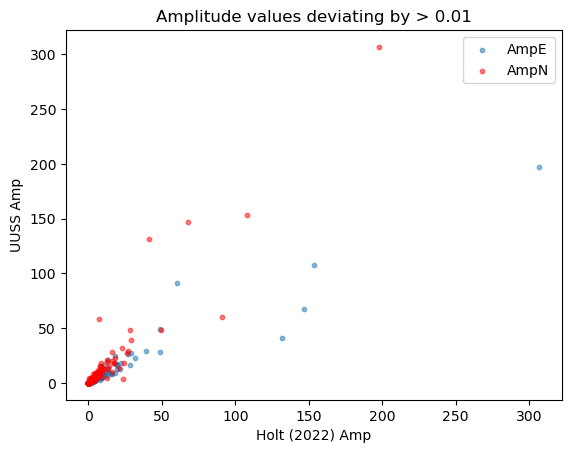

In [66]:
plt.scatter(diff_ampE['AmpE_x'], diff_ampE['AmpE_y'], alpha=0.5, s=10, label='AmpE')
plt.scatter(diff_ampN['AmpN_x'], diff_ampN['AmpN_y'], alpha=0.5, s=10, color='r', label='AmpN')

plt.xlabel('Holt (2022) Amp')
plt.ylabel('UUSS Amp')
plt.title(f"Amplitude values deviating by > {amp_tol}")
plt.legend()

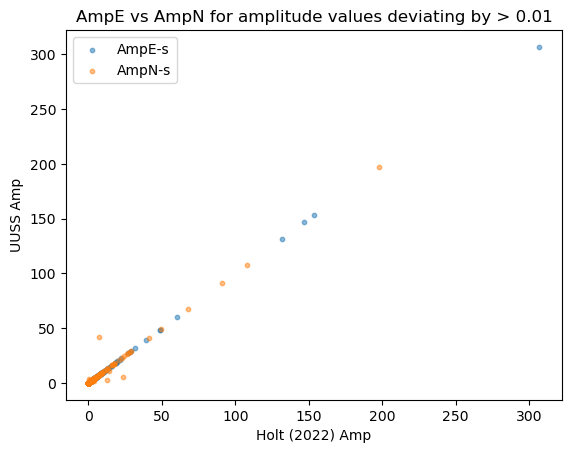

In [67]:
plt.scatter(diff_ampE['AmpE_x'], diff_ampE['AmpN_y'], alpha=0.5, s=10, label='AmpE-s')
plt.scatter(diff_ampN['AmpN_x'], diff_ampN['AmpE_y'], alpha=0.5, s=10, label='AmpN-s')

plt.xlabel('Holt (2022) Amp')
plt.ylabel('UUSS Amp')
plt.title(f"AmpE vs AmpN for amplitude values deviating by > {amp_tol}")
plt.legend()

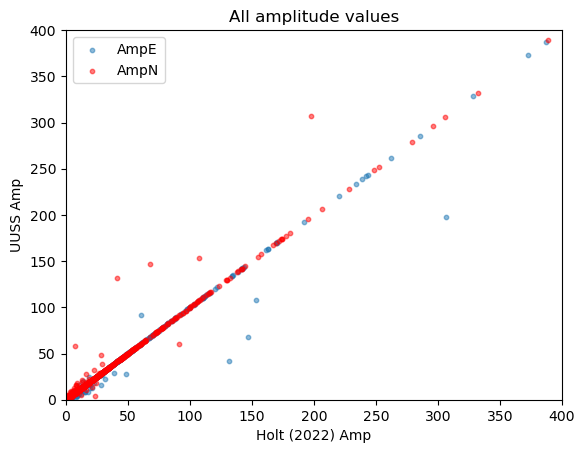

In [68]:
plt.scatter(inner_merge['AmpE_x'], inner_merge['AmpE_y'], alpha=0.5, s=10, label='AmpE')
plt.scatter(inner_merge['AmpN_x'], inner_merge['AmpN_y'], alpha=0.5, s=10, color='r', label='AmpN')

plt.xlim([0, 400])
plt.ylim([0, 400])

plt.xlabel('Holt (2022) Amp')
plt.ylabel('UUSS Amp')
plt.title(f"All amplitude values")
plt.legend()

Average half amps are much closer... This is because the main reason for the amplitude differences are that they are assigned to the opposite channels. Likely borehole stations. 

In [69]:
diff_halfAmp = inner_merge[abs(inner_merge['halfAmpH_x'] - inner_merge['halfAmpH_y']) > amp_tol]
print(f'There are {diff_halfAmp.shape[0]} halfAmpH values that deviate by > {amp_tol} units in the two catalogs. Occur at these stations...')
diff_halfAmp['Sta'].value_counts()

There are 20 halfAmpH values that deviate by > 0.01 units in the two catalogs. Occur at these stations...


Sta
YMR     6
YFT     5
YHB     5
LKWY    3
YNR     1
Name: count, dtype: int64

In [70]:
diff_halfAmp[['AmpE_x', 'AmpN_x', 'halfAmpH_x', 'AmpE_y', 'AmpN_y','halfAmpH_y']]

,AmpE_x,AmpN_x,halfAmpH_x,AmpE_y,AmpN_y,halfAmpH_y
1149,1.397816,3.693860,1.272919,1.397816,1.929716,0.831883
1150,5.246729,23.567886,7.203654,5.246729,3.693860,2.235147
1151,10.487020,14.117985,6.151251,10.487020,15.591166,6.519547
1216,0.179695,0.165957,0.086413,0.179695,0.307944,0.121910
1217,1.164593,0.665891,0.457621,1.164593,1.796179,0.740193
1225,0.970253,0.447455,0.354427,0.970253,1.235565,0.551455
5130,0.840860,0.224133,0.266248,0.840860,1.092774,0.483409
5815,0.923520,1.264889,0.547102,0.923520,0.579274,0.375698
5816,1.150595,1.172030,0.580656,1.150595,1.264889,0.603871
5817,0.750487,0.860025,0.402628,0.750487,1.172030,0.480629


(0.0, 400.0)

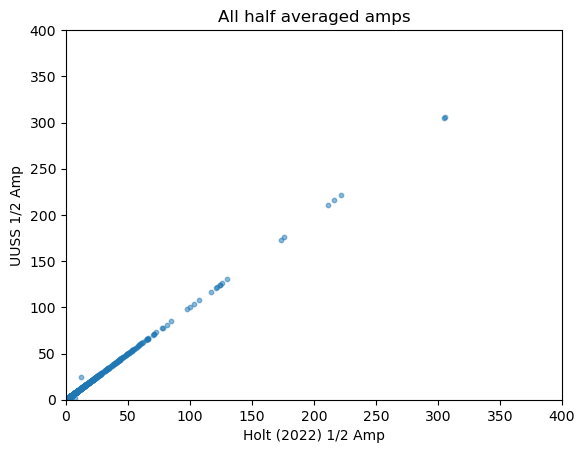

In [71]:
plt.scatter(inner_merge['halfAmpH_x'], inner_merge['halfAmpH_y'], alpha=0.5, s=10)
plt.xlabel('Holt (2022) 1/2 Amp')
plt.ylabel('UUSS 1/2 Amp')
plt.title(f"All half averaged amps")
plt.xlim([0, 400])
plt.ylim([0, 400])


In [72]:
dmin_tol = 0.5
print(f"{inner_merge[abs(inner_merge['Dmin_x'] - inner_merge['Dmin_y'] )> dmin_tol].drop_duplicates('Evid').shape[0]}/{inner_merge['Evid'].unique().shape[0]} events have Dmin differences > than {dmin_tol} km")

99/4892 events have Dmin differences > than 0.5 km


In [73]:
inner_merge.iloc[np.where(abs(inner_merge['EqDep_x'] - inner_merge["EqDep_y"]) > 1e-3)][['Evid', 'EqDep_x', 'EqDep_y']]

,Evid,EqDep_x,EqDep_y
1015,60022017,17.96,18.05
1016,60022017,17.96,18.05
7424,60137247,14.52,14.53
7425,60137247,14.52,14.53
7426,60137247,14.52,14.53
7427,60137247,14.52,14.53


In [74]:
assert np.array_equal(inner_merge['CatMag_x'], inner_merge["CatMag_y"]), 'Catalogs have different magnitude values'
assert np.allclose(inner_merge['EqDep_x'], inner_merge["EqDep_y"], rtol=1e-2), 'Catalogs have different depths'
assert np.allclose(inner_merge['EqLon_x'], inner_merge["EqLon_y"], rtol=1e-3), 'Catalogs have different lons'
assert np.allclose(inner_merge['EqLat_x'], inner_merge["EqLat_y"], rtol=1e-3), 'Catalogs have different lats'

In [75]:
print("All large differences in Repi are at..")
inner_merge[inner_merge['Repi_x'] - inner_merge['Repi_y'] > 1][['Sta', 'Repi_x', "Repi_y"]].value_counts('Sta')

All large differences in Repi are at..


Sta
BOZ    92
Name: count, dtype: int64

In [76]:
inner_merge[inner_merge['Repi_x'] - inner_merge['Repi_y'] > 1][['Sta', 'Repi_x', "Repi_y", 'SLat_x', 'SLat_y', 'SLon_x', 'SLon_y']]

,Sta,Repi_x,Repi_y,SLat_x,SLat_y,SLon_x,SLon_y
29,BOZ,146.8,141.469245,45.59697,45.59697,-111.62967,-111.62967
57,BOZ,147.2,141.927210,45.59697,45.59697,-111.62967,-111.62967
63,BOZ,146.5,141.254338,45.59697,45.59697,-111.62967,-111.62967
72,BOZ,146.9,141.568475,45.59697,45.59697,-111.62967,-111.62967
128,BOZ,146.3,140.969317,45.59697,45.59697,-111.62967,-111.62967
...,...,...,...,...,...,...,...
3012,BOZ,104.4,99.525830,45.59697,45.59697,-111.62967,-111.62967
3050,BOZ,104.4,99.544823,45.59697,45.59697,-111.62967,-111.62967
3123,BOZ,103.1,98.252699,45.59697,45.59697,-111.62967,-111.62967
3178,BOZ,103.7,98.851556,45.59697,45.59697,-111.62967,-111.62967


In [77]:
inner_merge['CatMagType'].value_counts()

CatMagType
l    15128
Name: count, dtype: int64

In [78]:
np.where(np.isnan(inner_merge['SnrE_x']))

(array([], dtype=int64),)

In [79]:
inner_merge[(np.isnan(inner_merge['SnrE_y'])) | (np.isnan(inner_merge['SnrN_y']))]

,Evid,Date,Time,EqLat_x,EqLon_x,EqDep_x,EqML,EqMC,N,Dmin_x,...,AmpN_y,UnN_y,PerN_y,SnrN_y,halfAmpH_y,CatMag_y,CatMagType,SourceE,SourceN,Dmin_y
436,60009035,2016-03-25,07:17:57.63,44.554,-110.969,10.28,1.78,-9.99,12,12.0,...,0.788747,mm,0.40,15.129239,0.408139,1.78,l,Jiggle,Jiggle,11.9
725,60014784,2018-02-18,04:47:55.51,44.740,-110.981,7.87,2.60,-9.99,15,3.0,...,3.346042,mm,0.24,NaN,1.279063,2.60,l,Jiggle,Jiggle,2.9
726,60014784,2018-02-18,04:47:55.51,44.740,-110.981,7.87,2.60,-9.99,15,3.0,...,3.798042,mm,0.54,NaN,2.232986,2.60,l,Jiggle,Jiggle,2.9
727,60014814,2018-02-18,09:23:59.47,44.736,-110.975,8.50,2.44,-9.99,21,4.0,...,2.274473,mm,0.24,NaN,0.870148,2.44,l,Jiggle,Jiggle,3.6
728,60014814,2018-02-18,09:23:59.47,44.736,-110.975,8.50,2.44,-9.99,21,4.0,...,2.749240,mm,0.24,NaN,1.573044,2.44,l,Jiggle,Jiggle,3.6
2929,60046047,2013-11-23,22:25:44.43,44.827,-111.015,12.60,2.12,-9.99,26,8.0,...,0.273314,mm,0.14,12.620424,0.164177,2.12,l,Jiggle,Jiggle,7.6


In [80]:
ml_df_reformEN['CatMagType'].value_counts()

CatMagType
l    26099
d      456
h       13
w        6
Name: count, dtype: int64

In [81]:
# There are some values with no SNR values, but I think I am going to leave these in 
ml_df_reformEN[(np.isnan(ml_df_reformEN['SnrE'])) | (np.isnan(ml_df_reformEN['SnrN']))][['CatMagType', 'SourceE', 'SourceN']].value_counts()

CatMagType  SourceE  SourceN
l           Jiggle   Jiggle     266
d           Jiggle   Jiggle      15
Name: count, dtype: int64

RT2 source

In [82]:
ml_df_reformEN[['SourceE', 'SourceN']].value_counts()

SourceE  SourceN
Jiggle   Jiggle     26362
RT2      RT2          153
         Jiggle        32
Jiggle   RT2           27
Name: count, dtype: int64

In [83]:
inner_merge[['SourceE', 'SourceN']].value_counts()

SourceE  SourceN
Jiggle   Jiggle     15056
RT2      Jiggle        30
         RT2           25
Jiggle   RT2           17
Name: count, dtype: int64

Holt (2022) have SNR values for picks that I think are from RT2 - have SNR 0 in my catalog 

In [84]:
inner_merge[inner_merge['SourceE'] == 'RT2']['SnrE_x'].describe()

count    55.000000
mean      2.205475
std       0.862923
min       1.010000
25%       1.640000
50%       2.150000
75%       2.535000
max       6.932994
Name: SnrE_x, dtype: float64

In [85]:
inner_merge[inner_merge['SourceN'] == 'RT2']['SnrN_x'].describe()

count    42.000000
mean      2.204023
std       1.018151
min       0.180000
25%       1.660000
50%       2.300000
75%       2.597500
max       7.058976
Name: SnrN_x, dtype: float64

In [86]:
ml_df_reformEN[(ml_df_reformEN['SourceN'] == 'RT2')][['SnrN']].max()

SnrN    0.0
dtype: float64

In [87]:
ml_df_reformEN[(ml_df_reformEN['SourceE'] == 'RT2')][['SnrE']].max()

SnrE    0.0
dtype: float64

# Save the reformatted yellowstone amplitude file

In [88]:
#ml_df_reformEN.to_csv(f'{catalog_dir}/yellowstoneAmplitudesForJamesML_allPrefMagTypes_20121007_230103.csv', index=False)

In [89]:
# source_df = ml_df_reformEN.groupby('Evid')[['SourceE', 'SourceN']].value_counts().reset_index()
# one_source_evs = source_df.drop_duplicates('Evid', keep=False)
# one_source_evs[(one_source_evs['SourceE'] == 'RT2') & (one_source_evs['SourceN'] == 'RT2')].shape

# Other filters that could be applied

Apply Filters: <- Probably use James's code for this part
- Remove amps that are not on two channels
- Rhyp <= 180 km
- Remove picks with poorly constrained depths for Repi < 50 km
    - Repi < 1.4 focal depths or < 5 km
- Remove p-p amps that differ by > 4 std
- Event must have >= 2 stats
